In [1]:
import sys
sys.path.append('../src/training-on-CM2.6')
%load_ext autoreload
%autoreload 3

import xarray as xr
import matplotlib.pyplot as plt
import xgcm
import cmocean
import numpy as np
from dask.diagnostics import ProgressBar
from helpers.plot_helpers import set_letters

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Optionally: read precomputed statistics

In [6]:
# Read dEdt datasets
dEdt_ref = xr.open_dataset('data/dEdt_ref.nc').__xarray_dataarray_variable__
dEdt_ann = xr.open_dataset('data/dEdt_ann.nc').__xarray_dataarray_variable__
dEdt_ann_offline = xr.open_dataset('data/dEdt_ann_offline.nc').__xarray_dataarray_variable__

# Read energy datasets
energy_control = xr.open_dataset('data/energy_control.nc')
energy_ann = xr.open_dataset('data/energy_ann.nc')
energy_ref = xr.open_dataset('data/energy_ref.nc')

In [7]:
import matplotlib as mpl
def plot(field, vmin=None, vmax=None, vcenter=0, cmap=cmocean.cm.balance, xticks=False, yticks=False, equal=True):
    norm = mpl.colors.SymLogNorm(linthresh=vmin, vmin=-vmax, vmax=vmax)
    im = field.plot.imshow(
        norm=norm,
        cmap=cmap,
        add_colorbar=False,
        interpolation='none',
        rasterized=True
    )

    if equal:
        plt.gca().axes.set_aspect('equal')
    
    plt.xlabel('')
    plt.ylabel('')
    
    lons = [10,30,50]
    if xticks:
        plt.xticks(lons, [f'${lon}^'+'{\circ}$E' for lon in lons])
    else:
        plt.xticks(lons, [''] * len(lons))

    lats = [-60, -40, -20, 0, 20, 40, 60]
    if yticks:
        lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
        plt.yticks(lats, lat_ticks)    
    else:
        plt.yticks(lats, ['']*len(lats))

    #plt.colorbar(im, shrink=shrink, orientation='vertical', ax=plt.gca(), extend='both').set_label(fontsize=13, label=label)
    return im

# Read snopshots corresponding to last 800 days of simulations with frequency of 5 days

In [4]:
control_simulation = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/snapshots*.nc', decode_times=False).sel(time=slice(29200.001,30000))

In [5]:
ann_simulation = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/May22-Coriolis-upd/snapshots*.nc', decode_times=False).sel(time=slice(29200.001,30000))

In [11]:
R32_filtered_coarsegrained = \
    xr.merge(
        [xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/merged_dataset.nc', decode_times=False).drop_vars(['hf','ef']),
         xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/interfaces-GMfilter.nc', decode_times=False)
        ]
    )

In [7]:
offline_skill = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/EXP1-offline.nc')

In [8]:
lores_static = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/static.nc', decode_times=False)

In [9]:
grid_lores = xgcm.Grid(lores_static.isel(time=0).drop_vars('time').squeeze(), coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'}
    },
    boundary={"X": 'periodic', 'Y': 'fill'},
    fill_value = {'Y':0})

In [10]:
lores_static['dxBu'] = grid_lores.interp(lores_static.dxCu, 'Y')
lores_static['dyBu'] = grid_lores.interp(lores_static.dyCu, 'Y')

lores_static['dxT'] = grid_lores.interp(lores_static.dxCu, 'X')
lores_static['dyT'] = grid_lores.interp(lores_static.dyCu, 'X')

# Computing depth-integrated energy from snapshot data

In [63]:
def APE(interface):
    '''
    Returns APE in units of kinetic energy per unit mass, i.e.
    m^3/s^2
    '''
    interface_rest = xr.DataArray([    0.,   -25.,   -75.,  -175.,  -300.,  -450.,  -625.,  -825.,
       -1050., -1300., -1600., -1950., -2350., -2850., -3400., -4000.], dims='zi')
    g = xr.DataArray([1.0e+01, 2.1e-03, 3.9e-03, 5.4e-03, 5.8e-03, 5.8e-03, 5.7e-03,
       5.3e-03, 4.8e-03, 4.2e-03, 3.7e-03, 3.1e-03, 2.4e-03, 1.7e-03,
       1.1e-03, 0.0e+00], dims='zi')
    
    coordinate_of_bottom = interface.isel(zi=-1).drop_vars(['zi'])
    
    hint = interface - interface_rest
    
    # Where bottom is upper than the rest interface
    hbot = np.maximum(coordinate_of_bottom - interface_rest,0)
    
    APE_instant = (0.5 * g * (hint**2))
    APE_constant = (0.5 * g * (hbot**2))
    
    return (APE_instant - APE_constant).sum('zi')

In [64]:
def energy(data):
    data = data.chunk({'zl':1})
    try:
        h = (data.e.isel(zi=slice(0,-1)).drop_vars('zi') - data.e.isel(zi=slice(1,None)).drop_vars('zi')).rename({'zi': 'zl'})
    except:
        h = data.h
    out = xr.Dataset()

    KEu = (data.u**2 * grid_lores.interp(h,'X') * 0.5).chunk({'yh':100}).mean('time').compute()
    KEv = (data.v**2 * grid_lores.interp(h,'Y') * 0.5).chunk({'xh':100}).mean('time').compute()
    
    out['KE'] = (grid_lores.interp(KEu,'X') + grid_lores.interp(KEv,'Y')).sum('zl')

    uom = data.u.chunk({'yh':100}).mean('time').compute()
    vom = data.v.chunk({'yq':100}).mean('time').compute()
    hm = h.chunk({'yh':100}).mean('time').compute()

    KEu = (uom**2 * grid_lores.interp(hm,'X') * 0.5)
    KEv = (vom**2 * grid_lores.interp(hm,'Y') * 0.5)

    out['MKE'] = (grid_lores.interp(KEu,'X') + grid_lores.interp(KEv,'Y')).sum('zl')

    out['EKE'] = out['KE'] - out['MKE']

    try:
        out['APE'] = APE(data.e).mean('time').compute()
        out['MPE'] = APE(data.e.mean('time')).compute()
        out['EPE'] = out['APE'] - out['MPE']
    except:
        pass
    

    return out

In [65]:
%%time
energy_control = energy(control_simulation)

CPU times: user 55.9 s, sys: 33.2 s, total: 1min 29s
Wall time: 2min 4s


In [66]:
%time energy_ann = energy(ann_simulation)

CPU times: user 55.8 s, sys: 34.5 s, total: 1min 30s
Wall time: 2min 4s


In [67]:
%time energy_ref = energy(R32_filtered_coarsegrained.rename({'hf':'h','uf':'u','vf':'v','ef':'e'}))

CPU times: user 18.3 s, sys: 14.5 s, total: 32.8 s
Wall time: 24.8 s


In [75]:
# energy_control.to_netcdf('data/energy_control.nc')
# energy_ann.to_netcdf('data/energy_ann.nc')
# energy_ref.to_netcdf('data/energy_ref.nc')

# Compute upscale KE transfer

In [28]:
with ProgressBar():
    dEdt_ref = (R32_filtered_coarsegrained.dEdt * R32_filtered_coarsegrained.hf).sum('zl').mean('time').compute()
    dEdt_ann = ((grid_lores.interp(ann_simulation.ZB2020u * ann_simulation.u, 'X') + grid_lores.interp(ann_simulation.ZB2020v * ann_simulation.v, 'Y')) * ann_simulation.h).sum('zl').mean('time').compute()
    dEdt_ann_offline = (offline_skill.dEdt * R32_filtered_coarsegrained.hf).sum('zl').mean('time').compute()

[########################################] | 100% Completed | 2.61 ss
[########################################] | 100% Completed | 61.88 s
[########################################] | 100% Completed | 1.91 ss


In [30]:
# dEdt_ref.to_netcdf('data/dEdt_ref.nc')
# dEdt_ann.to_netcdf('data/dEdt_ann.nc')
# dEdt_ann_offline.to_netcdf('data/dEdt_ann_offline.nc')

# Figure S1

In [58]:
from helpers.plot_helpers import default_rcParams
default_rcParams({'font.size': 11, 'xtick.labelsize':14, 'ytick.labelsize':14, 'figure.subplot.wspace':0.1, 'figure.subplot.hspace':0.2})

Colorbar-like object skipped


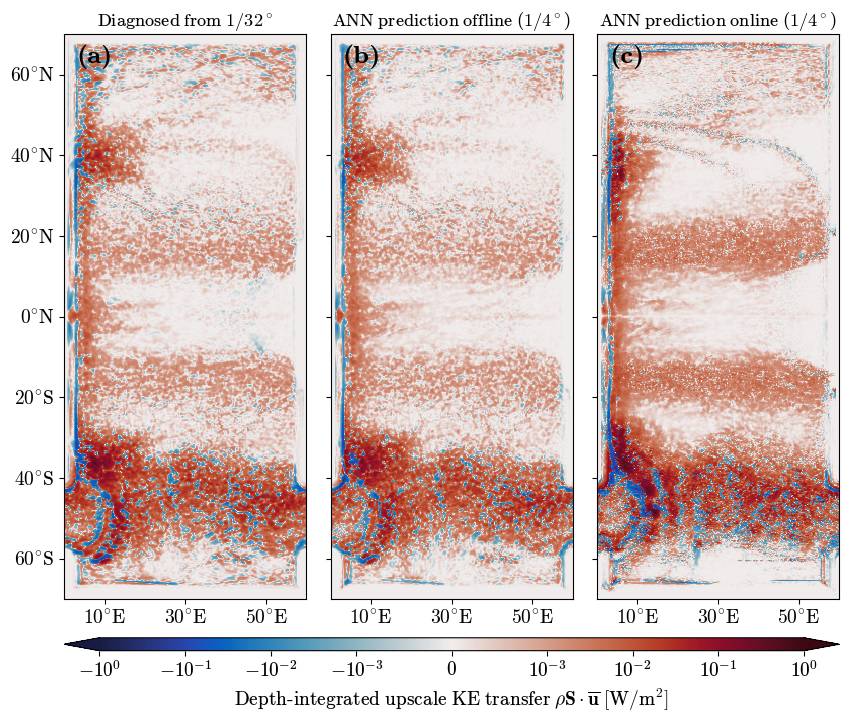

In [59]:
rho0 = 1035.
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plot(rho0*(dEdt_ref), vmin=1e-3, vmax=1,yticks=True, xticks=True)
plt.title('Diagnosed from $1/32^\circ$')
plt.subplot(1,3,2)
plot(rho0*(dEdt_ann_offline), vmin=1e-3, vmax=1, xticks=True)
plt.title('ANN prediction offline ($1/4^\circ$)')
plt.subplot(1,3,3)
im = plot(rho0*(dEdt_ann), vmin=1e-3, vmax=1, xticks=True)
plt.title('ANN prediction online ($1/4^\circ$)')

plt.colorbar(im, ax=plt.gcf().axes, orientation='horizontal', extend='both', aspect=60, shrink=1, pad=0.05).set_label(fontsize=14, label='Depth-integrated upscale KE transfer $\\rho \\mathbf{S} \\cdot \\overline{\\mathbf{u}}$ [W/m$^2$]')
set_letters(x=0.05,y=0.95,fontsize=18)
plt.savefig('figures/Figure-S1.pdf', bbox_inches='tight', dpi=150)

# Figure 2

In [56]:
from helpers.plot_helpers import default_rcParams
default_rcParams({'font.size': 11, 'xtick.labelsize':14, 'ytick.labelsize':14, 'figure.subplot.wspace':0.1, 'figure.subplot.hspace':0.2})

Colorbar-like object skipped
Colorbar-like object skipped
Colorbar-like object skipped


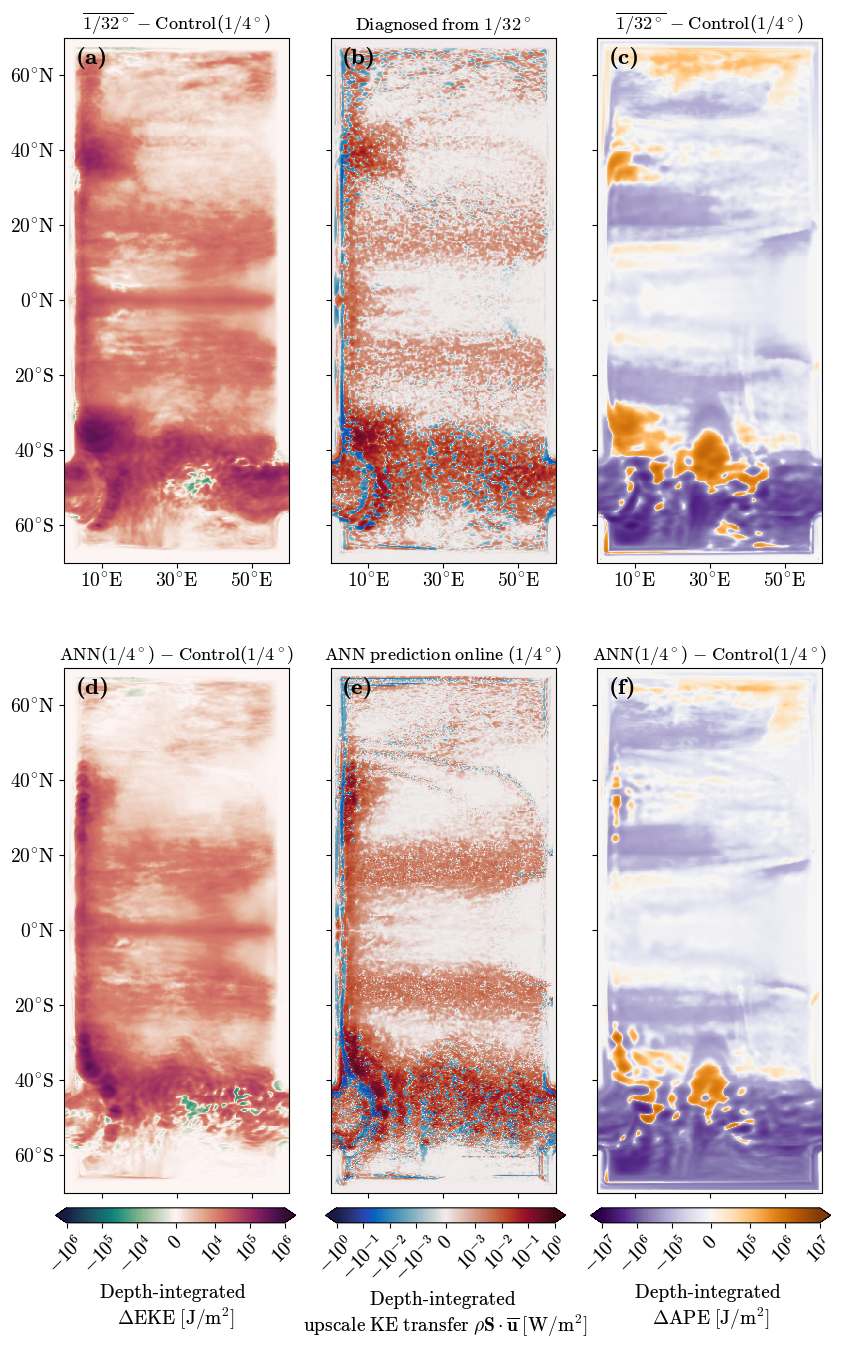

In [57]:
rho0 = 1035.
equal=True
plt.figure(figsize=(10,15))
plt.subplot(2,3,1)
plot(rho0*(energy_ref.EKE - energy_control.EKE), vmin=1e+4, vmax=1e+6, yticks=True, xticks=True, cmap=cmocean.cm.curl, equal=equal)
plt.title('$\overline{1/32^\circ}$ $-$ Control($1/4^\circ$)')
plt.subplot(2,3,2)
plot(rho0*(dEdt_ref), vmin=1e-3, vmax=1, xticks=True, equal=equal)
plt.title('Diagnosed from $1/32^\circ$')
plt.subplot(2,3,3)
plot(rho0*(energy_ref.APE - energy_control.APE), vmin=1e+5, vmax=1e+7, xticks=True, cmap=plt.cm.PuOr_r, equal=equal)
plt.title('$\overline{1/32^\circ}$ $-$ Control($1/4^\circ$)')

plt.subplot(2,3,4)
im_EKE = plot(rho0*(energy_ann.EKE - energy_control.EKE), vmin=1e+4, vmax=1e+6, yticks=True, cmap=cmocean.cm.curl, equal=equal)
plt.title('ANN($1/4^\circ$) $-$ Control($1/4^\circ$)')
plt.subplot(2,3,5)
im_SGS = plot(rho0*(dEdt_ann), vmin=1e-3, vmax=1, equal=equal)
plt.title('ANN prediction online ($1/4^\circ$)')
plt.subplot(2,3,6)
im_APE = plot(rho0*(energy_ann.APE - energy_control.APE), vmin=1e+5, vmax=1e+7, cmap=plt.cm.PuOr_r, equal=equal)
plt.title('ANN($1/4^\circ$) $-$ Control($1/4^\circ$)')

cax = plt.gcf().add_axes([0.125, 0.09, 0.24, 0.01])  
cbar = plt.colorbar(im_EKE, cax=cax, orientation='horizontal', extend='both')
cbar.set_label(label='Depth-integrated \n$\Delta$EKE [J/m$^2$]', fontsize=14)
cbar.ax.xaxis.set_tick_params(rotation=45)

cax = plt.gcf().add_axes([0.395, 0.09, 0.24, 0.01])  
cbar = plt.colorbar(im_SGS, cax=cax, orientation='horizontal', extend='both')
cbar.set_label(label='Depth-integrated \nupscale KE transfer $\\rho \\mathbf{S} \\cdot \\overline{\\mathbf{u}}$ [W/m$^2$]', fontsize=14)
cbar.ax.xaxis.set_tick_params(rotation=45)

cax = plt.gcf().add_axes([0.66, 0.09, 0.24, 0.01])  
cbar = plt.colorbar(im_APE, cax=cax, orientation='horizontal', extend='both')
cbar.set_label(label='Depth-integrated \n$\Delta$APE [J/m$^2$]', fontsize=14)
cbar.ax.xaxis.set_tick_params(rotation=45)

set_letters(x=0.05,y=0.95,fontsize=16)

plt.savefig('figures/Figure-2.pdf', dpi=150)